# How to transpile circuits in a pulse-efficient way?

In this notebook, we show readers how to transpile circuits in a pulse-efficient way by transpiling the two-qubit gates into the [`RZXGate`](https://qiskit.org/documentation/stubs/qiskit.circuit.library.RZXGate.html). The 'RZXGate' is implemented by turning on the two-qubit $Z\otimes X$ interaction by applying echoed cross-resonance pulses through the control electronics, hence serving as a continuous gate set native to the hardware. We show examples where this method results in shorter circuit depth and duration. Since qubits have a limited coherence time, a shorter total circuit duration is desirable. The pulse-efficient transpilation has been shown to give more accurate results in the quantum approximate optimization algorithm applied to MAXCUT (see reference [here](https://journals.aps.org/prresearch/abstract/10.1103/PhysRevResearch.3.043088)). We demonstrate how to implement this technique to transpile a relevant circuit in simulating quantum dynamics. And the Runtime result from the hardware suggests that the `RZXGate` type of transpilation produces more accurate results.

In [255]:
# for circuit construction
from qiskit.circuit import QuantumCircuit, QuantumRegister, Parameter
from qiskit.circuit.library import PauliEvolutionGate
from qiskit.quantum_info import SparsePauliOp

# for transpilation
from qiskit.providers import Backend
from qiskit.compiler import transpile, schedule as build_schedule
from qiskit.transpiler import PassManager, CouplingMap
from qiskit.transpiler.passes import (Optimize1qGatesDecomposition,
                                      RZXCalibrationBuilder,  
                                      FullAncillaAllocation,                 
                                      )

# for running circuits on backend
from qiskit_ibm_runtime import QiskitRuntimeService

# other basic modules
import numpy as np
import random
from typing import Dict, List
import matplotlib.pyplot as plt

To show pulse-efficient transpilation, we will pick a backend that supports OpenPulse extension. Note that the current implementation only supports backend that has `ECRGate` as the two-qubit basis gate.

In [256]:
service = QiskitRuntimeService(channel="ibm_quantum")

In [257]:
ecr_backend = service.least_busy(simulator=False, operational=True, open_pulse=True, filters=lambda x: ('ecr' in x.basis_gates))

When running a generic quantum circuit on the hardware, the circuits need to be transpired into a basic set of gates so that it is compatible with a target backend. This process is handled by the [`qiskit.transpiler`](https://qiskit.org/documentation/apidoc/transpiler.html), and in the how-to guide, we will introduce two ways of defining the basis gate set.

In [258]:
# standard way: basis gate set that includes ECR gate
BASIS_GATES = ['ecr', 'x', 'sx', 'rz']

# pulse efficient way: basis gate set that includes the pulse RZX gate
BASIS_GATES = ['rzx', 'x', 'sx', 'rz']

A standard way to transpile is to transpile into a basis gate set that includes a two-qubit entangling gate. Depending on the backend, the two-qubit entangling gate is either a `CXGate` or an `ECRGate`, which are pre-calibrated on the hardware. In practice, the two-qubit entangling gates have relatively long gate times compared with single-qubit gates and are one of the main sources of errors. In this guide, we show a method to transpile into a `RZXGate` pulse gate. It is a continuous two-qubit entangling gate with the angle $\theta$ as a gate parameter and has adjustable gate time accordingly. In some use cases, we show that the transpiled circuits are pulse-efficient, meaning they have fewer two-qubit gates and a shorter circuit duration. This is beneficial since the qubits have a finite coherence time. 

The recipe to transpile into `RZXGate` has two main steps:

* First, we decompose the input circuit in terms of single-qubit gates and the `RZXGate`;
* Strech the pulse schedule according to the desired rotation angle and attach the new schedule to the 'RZXGate's.

# Qiskit Patterns Step 1: build trotterized evolution     
Let's start by looking at a simple example circuit on two qubits. The circuit example we use here simulates the dynamics generated by the Hamiltonian $H = - J \sum_{i,j}Z_i\otimes Z_j + h\sum_{i}X_i$. To approximate the dynamics, we implement its trotterized evolution using [`PauliEvolutionGate`](https://qiskit.org/documentation/stubs/qiskit.circuit.library.PauliEvolutionGate.html) pametrized by $J$, $h$ and the trotterized time step $t$.

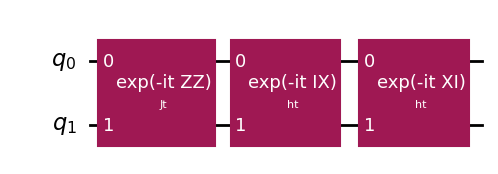

In [259]:
def build_trotter_evolution(num_qubits: int, rep = 1):
    Jt = Parameter('Jt')
    ht = Parameter('ht')
    qr = QuantumRegister(num_qubits, 'q')
    qc = QuantumCircuit(qr)
    even_indices = [i for i in range(0, num_qubits-1, 2)]
    odd_indices = [i for i in range(1, num_qubits-1, 2)]
    for _ in range(rep):
        for i in odd_indices + even_indices:
            ZZ_term = 'I' * (num_qubits - i - 2) + 'ZZ' + 'I' * i
            UU = PauliEvolutionGate(SparsePauliOp([ZZ_term]), time=Jt)
            qc.append(UU, qr)
        for i in range(num_qubits):
            X_term = 'I' * (num_qubits - i - 1) + 'X' + 'I' * i 
            UU = PauliEvolutionGate(SparsePauliOp([X_term]), time=ht)
            qc.append(UU, qr)
    return qc

qc = build_trotter_evolution(num_qubits=2)
qc.draw('mpl', fold=-1)

# Qiskit Patterns Step 2: Transpile

Let's compare the following two transpilation methods:
1. transpile to the standard gate set with the ECR gate
2. transpile into a basis gate set with `RZXGate`
We will compare the two-qubit circuit depth of the transpiled circuits. We only count the two-qubit gates here since they are considered more 'costly' as they have longer gate time than single-qubit gates and have a higher error rate.

two-qubit circuit depth = 2


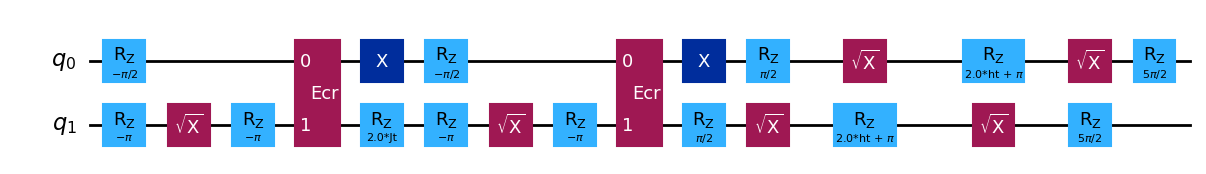

In [260]:
# transpile into ECR gates
ecr_circ = transpile(qc, basis_gates=['ecr', 'x', 'sx', 'rz'])
print(f'two-qubit circuit depth = {ecr_circ.depth(lambda x: x[0].num_qubits == 2)}')
ecr_circ.draw('mpl')

two-qubit circuit depth = 1


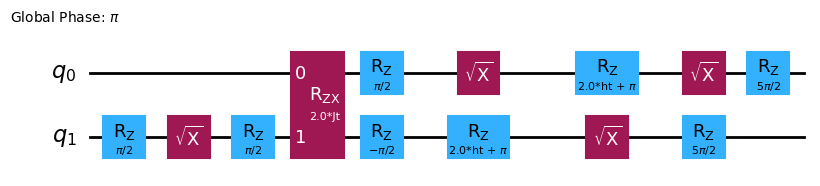

In [261]:
# transpile into RZX gates
rzx_circ = transpile(qc, basis_gates=['rzx', 'x', 'sx', 'rz'])
print(f'two-qubit circuit depth = {rzx_circ.depth(lambda x: x[0].num_qubits == 2)}')
rzx_circ.draw('mpl', fold=-1)

The RZX transpilation results in only one `RZXGate`s, which effectively shortens the two-qubit circuit depth by half compared with the ECR transpilation! In fact, this is a general result: any 2-qubit unitary can be represented in the `RZXGate` decomposition with at most three `RZXGate` via the so-called KAK decomposition. 

Notice that in the `RZXGate` transpiled circuit, the `RZXGate`s are parameterized by the angle `Jt.` To properly implement the gate, we need to instruct the hardware on the proper pulse schedule. This is done by creating a customized [pulse gate](https://qiskit.org/documentation/tutorials/circuits_advanced/05_pulse_gates.html) by attaching a stretched pulse schedule to the `RZXGate` based on the desired entangling angle. 

To show how to do this, we first pick a backend to transpile the circuit to and assign values to the circuit paramters.

In [262]:
J = 1
h = 0
t = random.uniform(0,np.pi)
params = rzx_circ.parameters
circ_params = {params[0]: J * t, 
               params[1]: h * t}
# bind the paramter to the circuit
rzx_circ.assign_parameters(circ_params, inplace=True)

The transpiler pass [`RZXCalibrationBuilder`](https://qiskit.org/documentation/stubs/qiskit.transpiler.passes.RZXCalibrationBuilder.html) can be used to attach the pulse schedule to the `RZXGate` by stretching the pre-calibrated pulse schedule for the ECR gate. This calibration information is stored in a [`InstructionScheduleMap`] object and is available for each `Backend`. 

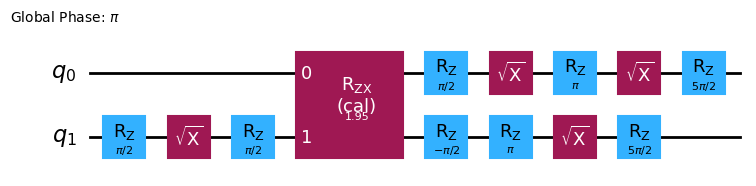

In [263]:
inst_sched_map = ecr_backend.defaults().instruction_schedule_map
channel_map = ecr_backend.configuration().qubit_channel_mapping
pass_manager = PassManager([RZXCalibrationBuilder(inst_sched_map, channel_map)])
rzx_circ = pass_manager.run(rzx_circ)
rzx_circ.draw('mpl', fold=-1)

Not all 2-qubit unitary will result in shorter circuit duration. It depends on the circuit parameters. To see this explicitly, let's perform transpilation for different parameters and get the circuit duration by [building pulse schedules](https://qiskit.org/documentation/tutorials/circuits_advanced/06_building_pulse_schedules.html) of the transpiled circuit.

### estimate circuit duration

In [264]:
# transpile to ECR and get circuit duration
def cal_ecr_circ_duration(circuit: QuantumCircuit, backend: Backend, params: Dict) -> int:
    # transpile circuit into ecr basis gate, get duration
    ecr_circ = transpile(circuit, backend=backend, basis_gates=['ecr', 'x', 'sx', 'rz'])
    # assign parameters
    parameters = ecr_circ.parameters
    params_dict = {parameters[0]: params['Jt'],
                parameters[1]: params['ht']}
    ecr_circ.assign_parameters(params_dict, inplace=True)
    # schedule
    circuits_transpiled = build_schedule(ecr_circ, backend)
    return circuits_transpiled.duration

# transpile to rzx and get circuit duration
def cal_rzx_circ_duration(circuit: QuantumCircuit, backend: Backend, params: Dict):
    # transpile
    rzx_circ = transpile(circuit, backend=backend, basis_gates=['rzx', 'x', 'sx', 'rz'])
    # assign parameters
    parameters = rzx_circ.parameters
    params_dict = {parameters[0]: params['Jt'],
                   parameters[1]: params['ht']}
    rzx_circ.assign_parameters(params_dict, inplace=True)
    # attach schedule
    inst_sched_map = backend.instruction_schedule_map
    channel_map = backend.configuration().qubit_channel_mapping
    pass_manager = PassManager([RZXCalibrationBuilder(inst_sched_map, channel_map)])
    rzx_circ = pass_manager.run(rzx_circ)
    # schedule
    rzx_schedule = build_schedule(rzx_circ, backend)
    return rzx_schedule.duration

Below, we sweep the entangling angle from $0$ to $\pi$ and compare which transpilation gives shorter circuit duration, the standard ECR transpilation or the `RZXGate` transpilation. 

In [265]:
angles = np.linspace(0, np.pi, 100)
ecr_durations = [cal_ecr_circ_duration(qc, ecr_backend, {'Jt': J*t, 'ht': h*t}) for t in angles]
rzx_durations = [cal_rzx_circ_duration(qc, ecr_backend, {'Jt': J*t, 'ht': h*t}) for t in angles]

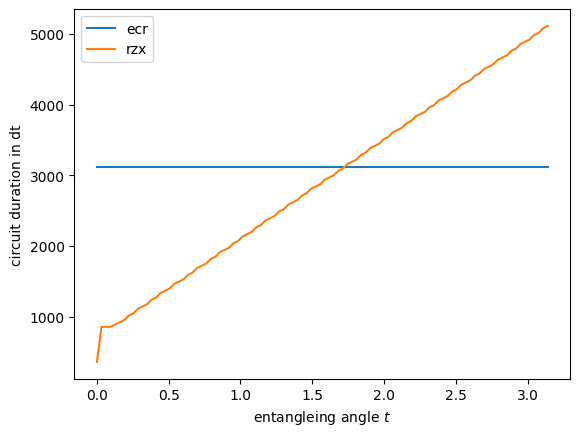

In [266]:
plt.plot(angles, ecr_durations,label='ecr')
plt.plot(angles, rzx_durations, label='rzx')
plt.xlabel(r'entangleing angle $t$')
plt.ylabel('circuit duration in dt')
plt.legend()

From the plot above, it is clear that the `RZXGate` transpilation results in shorter circuit duration for small entangling angles

### A larger example
Let's extend our example to a 1D spin chain of $N=21$ qubits. We follow the same steps to transpile into a basis gate set that includes either an `ecr` or a `rzx` gate. This is what the trotterized evolution circuit looks like.

In [223]:
num_qubits = 21
evol = build_trotter_evolution(num_qubits=num_qubits, rep=10)

Initialize the qubit state in the `0101...01` antiferromagnetic state, then compose the evolution circuit `evol` after the state initialization. At least, we assign circuit parameters $Jt=0.1$ and $ht=0$. 

In [224]:
qr = QuantumRegister(num_qubits, 'q')
qc = QuantumCircuit(qr) 
# state initialization
for i in range(0, num_qubits, 2):
    qc.x(i)

# evolve
qc.compose(evol, inplace=True)

# assign parameters
parameters = qc.parameters
qc.assign_parameters({parameters[0]: 0.1, parameters[1]: 0}, inplace=True)

Now, we are ready to perform transpilation. As an example, we will transpile to run on the backend `ibm_auckland`. We define two functions: one to transpile into a basis gate set includes the `ecr` gate, and the other includes the `rzx` gate.

In [225]:
def transpile_to_ecr(circuit: QuantumCircuit, 
                    layout: List,
                     backend: Backend):
    BASIS_GATES = ['ecr', 'x', 'sx', 'rz']
    # transpile
    ecr_circ = transpile(circuit, basis_gates=BASIS_GATES, backend=backend, initial_layout=layout, layout_method='trivial', optimization_level=1)
    print(f'ECR transpile: two-qubit circuit depth = {ecr_circ.depth(lambda x: x[0].num_qubits == 2)}')
    return ecr_circ

def transpile_to_rzx(circuit: QuantumCircuit, 
                     layout: List,
                     backend: Backend):
    BASIS_GATES = ['rzx', 'x', 'sx', 'rz']
    # transpile
    rzx_circ = transpile(qc, basis_gates= BASIS_GATES, backend=backend, initial_layout=layout, layout_method='trivial',  optimization_level=1)
    # optimize 1q
    pm = PassManager([Optimize1qGatesDecomposition(["rzx", "x", "sx", "rz" ])])
    rzx_circ = pm.run(rzx_circ)
    # attach schedule
    inst_sched_map = backend.defaults().instruction_schedule_map
    channel_map = backend.configuration().qubit_channel_mapping

    pass_manager = PassManager([
                                RZXCalibrationBuilder(inst_sched_map, channel_map)],
                                FullAncillaAllocation(CouplingMap(backend.configuration().coupling_map)))
    rzx_circ = pass_manager.run(rzx_circ)
    print(f'RZX transpile: two-qubit circuit depth = {rzx_circ.depth(lambda x: x[0].num_qubits == 2)}')
    return rzx_circ

In [226]:
# map to physical qubits that form 1D chain
layout = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 17, 30, 31, 32, 36, 51, 50, 49]

# transpile into ECR gates
ecr_circ = transpile_to_ecr(qc, layout=layout, backend=ecr_backend)
print(f'ECR circuit duration: {build_schedule(ecr_circ, ecr_backend).duration*ecr_backend.dt*10**6} us')
# transpile into RZX gates
rzx_circ = transpile_to_rzx(qc, layout=layout, backend=ecr_backend)
print(f'RZX circuit duration: {build_schedule(rzx_circ, ecr_backend).duration*ecr_backend.dt*10**6} us')


ECR transpile: two-qubit circuit depth = 40
ECR circuit duration: 30.06 us
RZX transpile: two-qubit circuit depth = 20
RZX circuit duration: 6.220000000000001 us


After transpilation, we notice:
* virtual qubits are mapped to physical qubits, and the transpiled circuits `ecr_circ` and `rzx_circ` are defined over all 27 physical qubits.
* gates are parsed in the basis gates. When we use the `rzx` based transpilation, all `RZXGate`s should have calibrations attached.
Layout information of the transpiled circuit is stored, and we can visualize it by calling `plot_circuit_layout.` Below, we see our original circuit `qc` on a 1D spin chain is mapped to the backend, and the physical qubits used are marked in black.

# Qiskit Patterns Step 3: execute

Finally, we run the `RZX`-based transpiled circuit on the hardware using the Runtime. To compare, we also run the `ECR`-based transpiled circuit. Since we already transpiled our circuits in a customized way, we set `skip_transpilation = True`. 

In [236]:
from qiskit_ibm_runtime import Options
from qiskit_ibm_runtime import Session, EstimatorV1 as Estimator
obs = SparsePauliOp('ZZ' + 'I' * (num_qubits - 2))
# Transpile the observable
ecr_obs= obs.apply_layout(ecr_circ.layout)
shots = 10000

options = Options()
options.execution.shots = shots
options.transpilation.skip_transpilation = True
options.resilience_level= 1
estimator = Estimator(session=Session(service, backend=ecr_backend), options=options)
rzx_job_zz = estimator.run(rzx_circ, ecr_obs)
ecr_job_zz = estimator.run(ecr_circ, ecr_obs)

# Qiskit Patterns Step 4: compare results

Note that under the condition $ht=0$, the Hamiltonian evolution preserves the initial $Z_iZ_{i+1}$ correlation, hence we know the exact value of ZZ correlatoin is -1. From the comparison below, the RZX-based pulse-efficient transpilation gives result closer to the exact value due to shorter circuit duration.

In [254]:
### Compare exact, standard ECR-based transpilation, vs RZX-based transpilation
print(f'exact_value = -1')
print(f'rzx_value = {rzx_job_zz.result().values[0]}' + '+/-' + f'{np.sqrt(rzx_job_zz.result().metadata[0]["variance"])/np.sqrt(shots)}')
print(f'ecr_value = {ecr_job_zz.result().values[0]}' + '+/-' + f'{np.sqrt(ecr_job_zz.result().metadata[0]["variance"])/np.sqrt(shots)}')

exact_value = -1
rzx_value = -0.5224599266631744+/-0.00936996979126887
ecr_value = -0.13240683311432325+/-0.010683042636226832


In this notebook, we started from a simple two-qubit example, and we see that the `RZXGate` transpilation shortens the circuit duration when the trotter step $t$ (which corresponds to the entangling angle in the `RZXGate`) is small. In the larger 21-qubit example, we have shown how to transpile and run the circuit with the `Estimator.` We have seen that the `RZXGate` transpilation produces results closer to the exact value.

To conclude, we have shown you how to transpile into `RZXGate`s. You may wonder if this method is useful for your circuit. Try it out on your own circuit using the `transpile_to_rzx()` function. To compare with the standard ECR-based transpilation, use the `transpile_to_ecr()` function. You can use the circuit duration calculator `cal_ecr_circ_duration` and `cal_rzx_circ_duration` to see if  `RZXGate` transpilation gives shorter circuits!

In [96]:
import numpy
print(f"numpy version {numpy.__version__}")

import qiskit_ibm_runtime
print(f"qiskit runtime version {qiskit_ibm_runtime.version.get_version_info()}")

import qiskit
print(f"qiskit version {qiskit.version.get_version_info()}")

numpy version 1.26.4
qiskit runtime version 0.22.0
qiskit version 1.0.0
